In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow as imshow
import numpy as np
import skimage.feature
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
from sklearn.decomposition import PCA
import pandas as pd
%matplotlib inline

c:\users\ellis\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ellis\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ellis\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\ellis\appd

In [2]:
def get_data():
    train_data = np.load('trnImage.npy')
    train_labels = np.load('trnLabel.npy')
    test_data = np.load('tstImage.npy')
    test_labels = np.load('tstLabel.npy')
    return train_data, train_labels, test_data, test_labels

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def get_var(train_data):
    mu = np.mean(train_data,axis=0)
    centred_train_data = train_data-mu
    U, S, Vt = np.linalg.svd(centred_train_data)
    # Calculate the variance explained by each of the principal components.
    percentage_variance_explained = S**2 / np.sum(S**2)
    plt.figure()
    plt.plot(percentage_variance_explained)
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage')
    plt.title('Percentage variance explained by each of the identified principal components')
    plt.show(block=False)
    val = input('Number of Components')
    return val

def reduce_dimensions(train_data, test_data):
    comp = get_var(train_data)
    comp = int(comp)
    pca = PCA(n_components=comp)
    train_data = pca.fit_transform(train_data)
    test_data = pca.transform(test_data)
    return train_data, test_data

In [4]:
def shuffle(data,classes):
    idx = np.random.permutation(len(classes))
    x,y = data[:,:,:,idx], classes[idx]
    return x,y

def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

In [5]:
def get_features(train_data,train_labels,test_data,test_labels):
    
    hog_images=[]
    hog_features=[]
    test_images=[]
    test_features=[]
    
    for i in range(1000):
        hog_feature, hog_as_image = computeFeatures(test_data[:,:,:,i])
        test_images.append(hog_as_image)
        test_features.append(hog_feature)
    
    
    for i in range(10000):
        hog_feature, hog_as_image = computeFeatures(train_data[:,:,:,i])
        hog_images.append(hog_as_image)
        hog_features.append(hog_feature)
        
    return hog_features,test_features,hog_images,test_images



In [6]:
def confusion_matrix_generator(y_test, pred):
    labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
                    'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    cm = confusion_matrix(y_test, pred)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [7]:
def svm():
    # Getting the data
    train_data, train_labels, test_data, test_labels = get_data()
    train_data,train_labels = shuffle(train_data,train_labels)
    test_data,test_labels = shuffle(test_data,test_labels)
    
    # Getting the features
    hog_features,test_features,hog_images,test_images = get_features(train_data,train_labels,
                                                                     test_data,test_labels)
    print(np.shape(hog_features))
    
    # Reshape the labels
    train_labels =  np.array(train_labels).reshape(len(train_labels),1).ravel()
    test_labels = np.array(test_labels).reshape(len(test_labels),1).ravel()
    
    # Normalising the data
    normaliser = StandardScaler().fit(hog_features)
    train_data = normaliser.transform(hog_features)
    test_data = normaliser.transform(test_features)
    train_data,test_data = reduce_dimensions(train_data,test_data)
    
    C = 1 # Reg value, higher value smaler margin of hyperplane (Avoid missclassifiying each training example)
    model = SVC(kernel='linear', C=C,verbose=True)
    model.fit(train_data, train_labels)
    
    # Testing
    predicted_labels = model.predict(test_data)
    
    print("Accuracy: "+str(accuracy_score(test_labels, predicted_labels)*100)+"%")
    print('\n')
    target_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
                    'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    print(classification_report(test_labels, predicted_labels, target_names=target_names))
    confusion_matrix_generator(test_labels,predicted_labels)

(10000, 324)


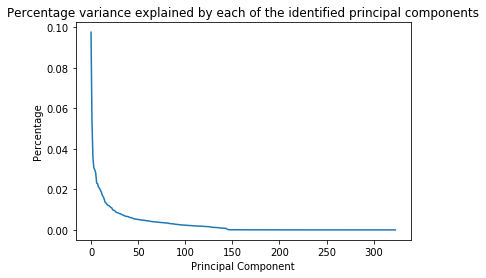

Number of Components100
[LibSVM]Accuracy: 51.2%


              precision    recall  f1-score   support

    Airplane       0.58      0.64      0.61       100
  Automobile       0.53      0.55      0.54       100
        Bird       0.35      0.39      0.37       100
         Cat       0.36      0.30      0.33       100
        Deer       0.50      0.53      0.51       100
         Dog       0.45      0.49      0.47       100
        Frog       0.52      0.53      0.53       100
       Horse       0.64      0.53      0.58       100
        Ship       0.56      0.55      0.55       100
       Truck       0.64      0.61      0.62       100

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000

[[64  2  6  3  2  0  2  3 15  3]
 [ 4 55  1  2  7  1  4  2 12 12]
 [ 9  3 39  6  7 18 10  4  2  2]
 [ 2  3 19 30 10 12 14  7  1  2]
 [ 4  6 12  9 53  5  7  1  2  1]
 [ 1  2 15 12  6 49  6  7 

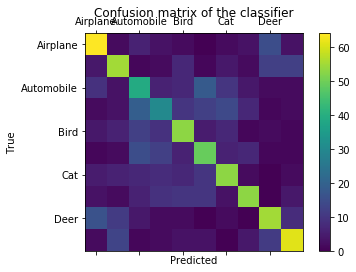

In [8]:
svm()

In [21]:
def neural_net():
    start = time.time()
    BATCH_SIZE = 238
    # Getting the data
    train_data, train_labels, test_data, test_labels = get_data()
    train_data,train_labels = shuffle(train_data,train_labels)
    test_data,test_labels = shuffle(test_data,test_labels)
    
    # Getting the features
    hog_features,test_features,hog_images,test_images = get_features(train_data,train_labels,
                                                                     test_data,test_labels)
    
    # Reshape the labels
    train_labels =  np.array(train_labels).reshape(len(train_labels),1).ravel()
    test_labels = np.array(test_labels).reshape(len(test_labels),1).ravel()
    
    # Normalising the data
    normaliser = StandardScaler().fit(hog_features)
    train_data = normaliser.transform(hog_features)
    test_data = normaliser.transform(test_features)
    
    number_of_classes = np.max(train_labels) + 1
    
    model = keras.Sequential()
    BIAS = 0.1
    
    # Create the input layer, this takes an argument of the input data shape (i.e. number of features)
    model.add(keras.layers.InputLayer(input_shape=(train_data.shape[1],)))

    # Create hidden layers
    model.add(keras.layers.Dense(22, activation='elu',use_bias=BIAS)) # first layer
    model.add(keras.layers.Dense(22, activation='elu',use_bias=BIAS)) # second layer

    # Create output layer to get predicted class labels.
    model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # fit model
    history = model.fit(train_data, train_labels,batch_size=BATCH_SIZE, 
                        validation_data=(test_data, test_labels), epochs=700, verbose=1, use_multiprocessing=True)

    # Predict probabilities of classes for the testing set.
    predicted_probabilities = model.predict(test_data)

    # Use argmax to get the predicted class label
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    end = time.time()
    
    print("Accuracy: "+str(accuracy_score(test_labels, predicted_labels)*100)+"%")
    print('\n')
    target_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
                    'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    print(classification_report(test_labels, predicted_labels, target_names=target_names))
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    confusion_matrix_generator(test_labels,predicted_labels)
    return ((end-start)/60)

Train on 10000 samples, validate on 1000 samples
Epoch 1/700
10000/10000 [==============================] - 0s 30us/sample - loss: 2.5621 - acc: 0.1301 - val_loss: 2.3712 - val_acc: 0.1600
Epoch 2/700
10000/10000 [==============================] - 0s 9us/sample - loss: 2.2321 - acc: 0.2072 - val_loss: 2.1655 - val_acc: 0.2290
Epoch 3/700
10000/10000 [==============================] - 0s 10us/sample - loss: 2.0725 - acc: 0.2596 - val_loss: 2.0435 - val_acc: 0.2750
Epoch 4/700
10000/10000 [==============================] - 0s 10us/sample - loss: 1.9694 - acc: 0.2953 - val_loss: 1.9628 - val_acc: 0.3050
Epoch 5/700
10000/10000 [==============================] - 0s 9us/sample - loss: 1.8954 - acc: 0.3248 - val_loss: 1.9005 - val_acc: 0.3310
Epoch 6/700
10000/10000 [==============================] - 0s 11us/sample - loss: 1.8388 - acc: 0.3504 - val_loss: 1.8527 - val_acc: 0.3490
Epoch 7/700
10000/10000 [==============================] - 0s 10us/sample - loss: 1.7908 - acc: 0.3685 - val_loss

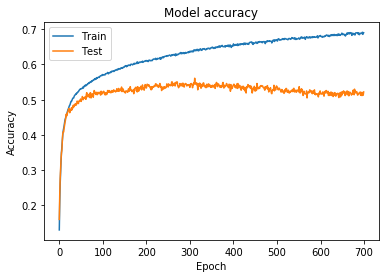

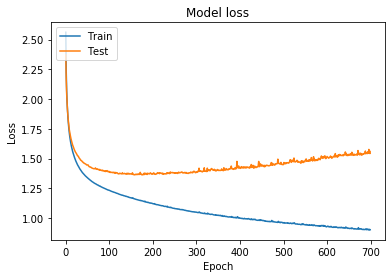

[[57  3  6  3  7  2  4  6 12  0]
 [ 4 52  2  4  3  0  2  4 16 13]
 [11  3 38  7 10 15  8  0  7  1]
 [ 5  3 14 32 11 16 11  5  2  1]
 [ 0  2  9  8 57  4  6  7  2  5]
 [ 3  2 12  8  8 46  8 12  0  1]
 [ 2  3  8  6  6  8 62  2  1  2]
 [ 1  2  4  6 11  7  3 61  0  5]
 [12  5  6  1  2  0  3  0 62  9]
 [ 5 14  3  5  2  2  2  5  7 55]]


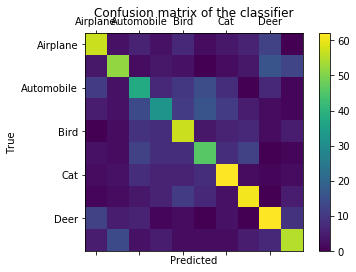

1.6386434237162273


In [22]:
the_time = neural_net()
print(the_time)

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def linear_da():
    train_data, train_labels, test_data, test_labels = get_data()
    train_data,train_labels = shuffle(train_data,train_labels)
    test_data,test_labels = shuffle(test_data,test_labels)
    
    # Getting the features
    hog_features,test_features,hog_images,test_images = get_features(train_data,train_labels,
                                                                     test_data,test_labels)
    
    # Reshape the labels
    train_labels =  np.array(train_labels).reshape(len(train_labels),1).ravel()
    test_labels = np.array(test_labels).reshape(len(test_labels),1).ravel()
    
    normaliser = StandardScaler().fit(hog_features)
    train_data = normaliser.transform(hog_features)
    test_data = normaliser.transform(test_features)
    
    lda = LinearDiscriminantAnalysis()
    lda.fit_transform(train_data,train_labels)
    predictions = lda.predict(test_data)
    
    correct = 0
    for index,pre in enumerate(predictions):
        if pre == test_labels[index]:
            correct += 1
    per_corr = (correct/len(test_labels))*100
    print('Accuracy: '+str(per_corr)+'%')

In [12]:
linear_da()

Accuracy: 49.4%


In [13]:
import sklearn.mixture
def gmm():
    train_data, train_labels, test_data, test_labels = get_data()
    train_data,train_labels = shuffle(train_data,train_labels)
    test_data,test_labels = shuffle(test_data,test_labels)
    
    # Getting the features
    hog_features,test_features,hog_images,test_images = get_features(train_data,train_labels,
                                                                     test_data,test_labels)
    
    # Reshape the labels
    train_labels =  np.array(train_labels).reshape(len(train_labels),1).ravel()
    test_labels = np.array(test_labels).reshape(len(test_labels),1).ravel()
    
    normaliser = StandardScaler().fit(hog_features)
    train_data = normaliser.transform(hog_features)
    test_data = normaliser.transform(test_features)
    
    gaussian = sklearn.mixture.GaussianMixture(n_components=10)
    gaussian.fit_predict(test_data,test_labels)
    predictions = gaussian.predict(test_data)
    
    correct = 0
    for index,pre in enumerate(predictions):
        if pre == test_labels[index]:
            correct += 1
    per_corr = (correct/len(test_labels))*100
    print('Accuracy: '+str(per_corr)+'%')

In [14]:
gmm()

Accuracy: 7.9%


In [15]:
import sklearn.cluster
def kmean():
    train_data, train_labels, test_data, test_labels = get_data()
    train_data,train_labels = shuffle(train_data,train_labels)
    test_data,test_labels = shuffle(test_data,test_labels)
    
    # Getting the features
    hog_features,test_features,hog_images,test_images = get_features(train_data,train_labels,
                                                                     test_data,test_labels)
    
    # Reshape the labels
    train_labels =  np.array(train_labels).reshape(len(train_labels),1).ravel()
    test_labels = np.array(test_labels).reshape(len(test_labels),1).ravel()
    
    normaliser = StandardScaler().fit(hog_features)
    train_data = normaliser.transform(hog_features)
    test_data = normaliser.transform(test_features)
    
    kmeans = sklearn.cluster.KMeans(n_clusters=10, max_iter=500)
    kmeans.fit_predict(train_data,train_labels)
    predictions = kmeans.predict(test_data)
    
    correct = 0
    for index,pre in enumerate(predictions):
        if pre == test_labels[index]:
            correct += 1
    per_corr = (correct/len(test_labels))*100
    print('Accuracy: '+str(per_corr)+'%')

In [16]:
kmean()

Accuracy: 11.3%


In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def linear_da_PCA():
    train_data, train_labels, test_data, test_labels = get_data()
    train_data,train_labels = shuffle(train_data,train_labels)
    test_data,test_labels = shuffle(test_data,test_labels)
    
    # Getting the features
    hog_features,test_features,hog_images,test_images = get_features(train_data,train_labels,
                                                                     test_data,test_labels)
    
    # Reshape the labels
    train_labels =  np.array(train_labels).reshape(len(train_labels),1).ravel()
    test_labels = np.array(test_labels).reshape(len(test_labels),1).ravel()
    
    normaliser = StandardScaler().fit(hog_features)
    train_data = normaliser.transform(hog_features)
    test_data = normaliser.transform(test_features)
    comp = get_var(train_data)
    comp = int(comp)
    pca = PCA(n_components=comp)
    principalComponents = pca.fit_transform(train_data)
    
    lda = LinearDiscriminantAnalysis()
    lda.fit_transform(principalComponents,train_labels)
    
    testComponents = pca.transform(test_data)
    predictions = lda.predict(testComponents)
    
    correct = 0
    for index,pre in enumerate(predictions):
        if pre == test_labels[index]:
            correct += 1
    per_corr = (correct/len(test_labels))*100
    print('Accuracy: '+str(per_corr)+'%')

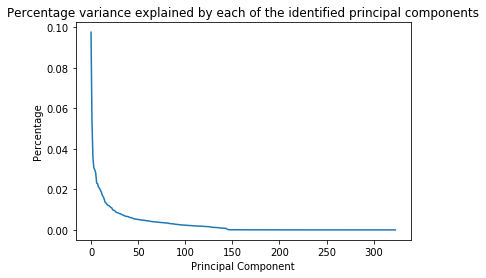

Number of Components100
Accuracy: 51.1%


In [18]:
linear_da_PCA()